This notebook is based on the DQN example from TensorFlow, which can be found in [this repo](https://github.com/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb). I've adapted it a bit to suit the AI Classroom training. This example uses the [TF-Agents](https://github.com/tensorflow/agents) RL framework, and more examples can be found in the GitHub repo for that project.

# Install dependencies

In [1]:
!sudo apt-get install -y xvfb ffmpeg x11-utils
!pip install 'gym==0.10.11'
!pip install 'imageio==2.4.0'
!pip install PILLOW
!pip install 'pyglet==1.3.2'
!pip install pyvirtualdisplay
!pip install --upgrade tensorflow-probability
!pip install tf-agents

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 11 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,977 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.6 [783 kB]
Fetched 993 kB in 1s (1,061 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 3.)
debconf: falling back t

# Imports

In [2]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

# Environment Setup

In [3]:
# We will use a "virtual environment" in this example. Here we are going to initialize
# a display object that will help us render OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [4]:
# Load the "Cart Pole" environment, which already exists within TF-Agents. You
# can also create this directly with something like OpenAI gym.
env_name = 'CartPole-v0'
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

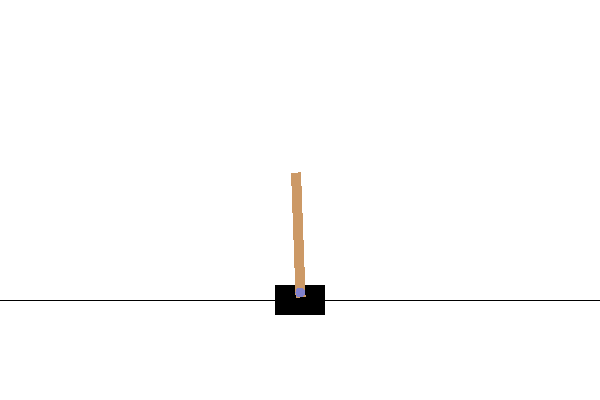

In [5]:
# Visualize a state of the environment. This environment is just a cart that
# rides along a rail. A pole is balanced on top of the cart, and our job with RL
# will be to create a policy that takes actions (moving the cart left and right)
# to keep the pole balanced on the cart.
train_py_env.reset()
PIL.Image.fromarray(train_py_env.render())

In [6]:
# Converts these environment to tensor representations to make them compatible 
# with Tensorflow-based agents.
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Define our Agent and some hyperparameters

In [7]:
# Number of iterations will be the number of steps of our training that we will
# complete where each step generated actions and state transitions. These 
# transitions get sent to a replay memory/ buffer for optimizing the policy
# network.
num_iterations = 20000 

# An initial number of transition collection steps to complete to fill out the
# memory buffer.
initial_collect_steps = 1000 

# After the initial collection, collect 1 transition per iteration.
collect_steps_per_iteration = 1

# The maximum length of our memory buffer.
replay_buffer_max_length = 100000 

# Update the policy network using batches of 64 transitions sampled from the
# replay buffer.
batch_size = 64 
learning_rate = 1e-3 
log_interval = 200 

# Number of episodes to use for evaluation.
num_eval_episodes = 10 
eval_interval = 1000 

In [8]:
# Define our deep Q-learning network.
fc_layer_params = (100,)
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [9]:
# Define some of the details of our agent for training purposes.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

# Initialize the agent.
agent.initialize()

In [10]:
# Define a function we will use to evaluate the policy network. A common evaluation
# metric is the the sum of rewards obtained while running a policy in an 
# environment for an episode. In this case, our episode runs for 200 steps/iterations,
# so the max return is 200.
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

# Initialize the Policies

In [11]:
# We will only use the policy network based on the DQN during evaluation and
# deployment of the resulting model.
eval_policy = agent.policy

# However, we will use a different policy during the exploration of the space.
collect_policy = agent.collect_policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

# Create the Replay/ Memory Buffer

In [12]:
# Create the replay buffer.
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

In [13]:
# Define some convenience functions we will use in filling the replay buffer.
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

In [14]:
# Collect data from an initial number of steps to seed the replay buffer.
collect_data(train_env, random_policy, replay_buffer, steps=100)

In [15]:
# Create a dataset using the replay_buffer, which allow us to iterate over and
# sample from the replay buffer.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)
iterator = iter(dataset)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


# Train the Agent policy network

In [16]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 200: loss = 13.613822937011719
step = 400: loss = 4.819139003753662
step = 600: loss = 2.801849126815796
step = 800: loss = 19.507579803466797
step = 1000: loss = 22.033170700073242
step = 1000: Average Return = 10.800000190734863
step = 1200: loss = 32.780860900878906
step = 1400: loss = 22.30136489868164
step = 1600: loss = 21.83877182006836
step = 1800: loss = 10.59023380279541
step = 2000: loss = 6.033289909362793
step = 2000: Average Return = 28.899999618530273
step = 2200: loss = 5.2944769859313965
step = 2400: loss = 6.478013515472412
step = 2600: loss = 32.73958969116211
step = 2800: loss = 26.823556900024414
step = 3000: loss = 11.231281280517578
step = 3000: Average Return = 85.80000305175781
step = 3200: loss = 22.649559020996094
step = 3

# Visualize our evaluation results and the trained agent

(1.1300004005432118, 250.0)

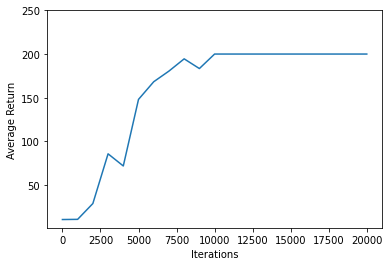

In [17]:
# Plot our return vs. the number of iterations in our training.
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

In [18]:
# Create a convenience function to help us embed videos of our policy at work.
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [19]:
# Create a video using our evaluation environment.
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")

In [20]:
# See if our above policy works qualitative differently than random actions.
create_policy_eval_video(random_policy, "random-agent")